In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
import statsmodels.api as sm

In [3]:
Filepath= r"Dataset.csv"
df=pd.read_csv(Filepath)
print(df)

                         Time  Latitude  Longitude  Depth/Km  Magnitude
0     2016-08-24 03:36:32.000   42.6983    13.2335       8.1        6.0
1     2016-08-24 03:37:26.580   42.7123    13.2533       9.0        4.5
2     2016-08-24 03:40:46.590   42.7647    13.1723       9.7        3.8
3     2016-08-24 03:41:38.900   42.7803    13.1683       9.7        3.9
4     2016-08-24 03:42:07.170   42.7798    13.1575       9.7        3.6
...                       ...       ...        ...       ...        ...
8081  2016-11-30 18:39:27.600   42.8903    13.0197      10.7        2.0
8082  2016-11-30 18:43:14.850   42.9443    13.2003       8.6        2.6
8083  2016-11-30 20:18:27.550   43.0092    13.1288       8.0        2.2
8084  2016-11-30 20:45:11.780   43.0197    13.1017       9.3        2.7
8085  2016-11-30 20:54:35.890   42.9935    13.0753       9.5        2.3

[8086 rows x 5 columns]


<AxesSubplot:xlabel='Latitude', ylabel='Count'>

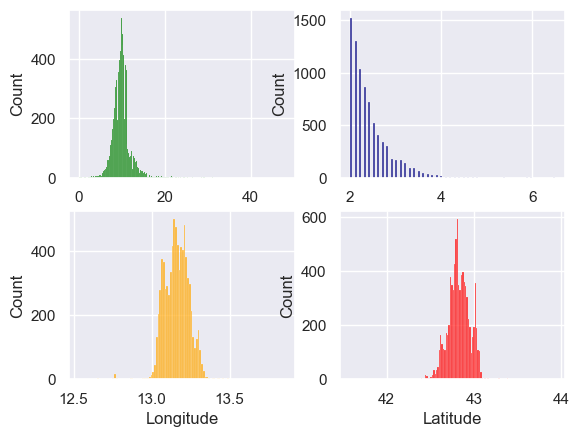

In [4]:
sns.set()
ghist, axes = plt.subplots(2, 2)
sns.histplot(data=df,x='Depth/Km',ax=axes[0,0],color='green')
sns.histplot(data=df,x='Magnitude',ax=axes[0,1],color='navy')
sns.histplot(data=df,x='Longitude',ax=axes[1,0],color='orange')
sns.histplot(data=df,x='Latitude',ax=axes[1,1],color='red')

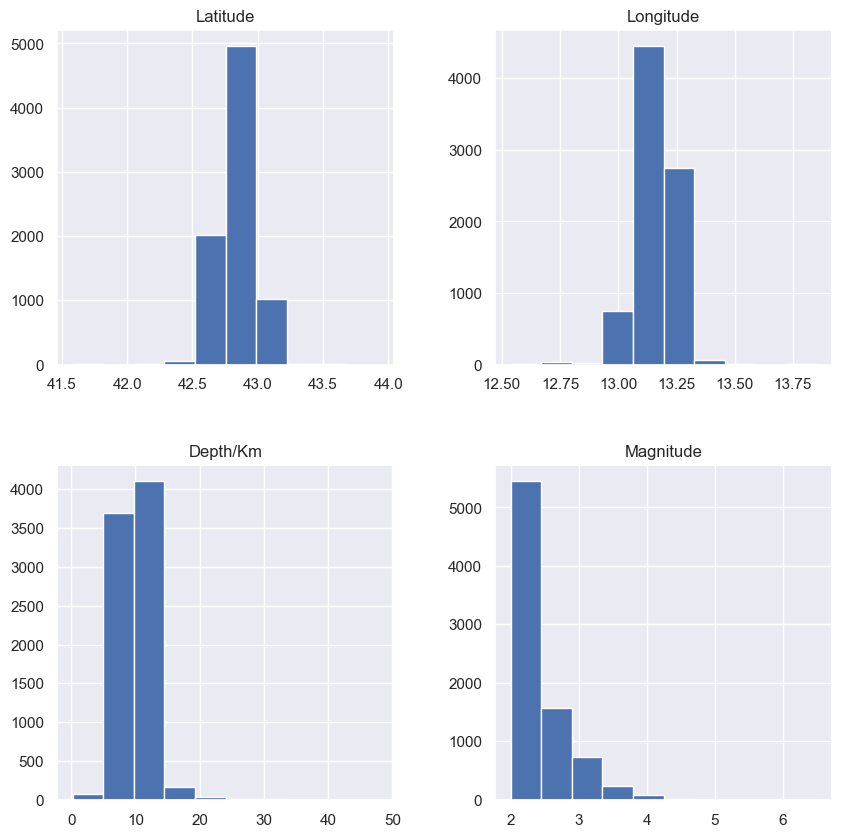

In [5]:
df.iloc[:,:].hist(figsize=(10,10))
plt.show()

In [6]:
df.describe()

,Latitude,Longitude,Depth/Km,Magnitude
count,8086.000000,8086.000000,8086.000000,8086.000000
mean,42.829557,13.161034,9.968328,2.398368
std,0.125927,0.083058,2.194064,0.426381
min,41.581300,12.537700,0.200000,2.000000
25%,42.751350,13.103200,8.900000,2.100000
50%,42.821800,13.160700,9.900000,2.300000
75%,42.911000,13.215650,10.800000,2.600000
max,43.927300,13.852500,47.900000,6.500000


<AxesSubplot:title={'center':'Mapa de calor con respecto \n a la correlación de la base de datos'}>

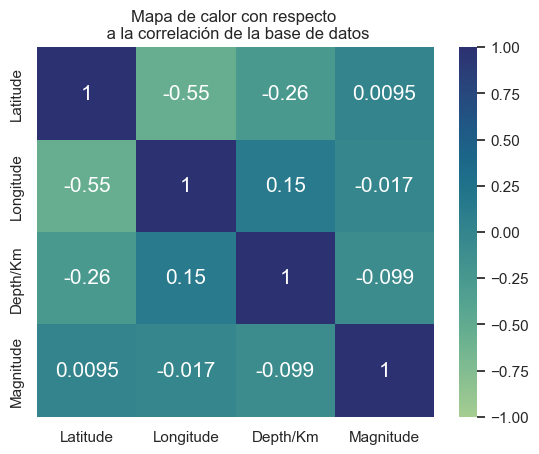

In [7]:
matriz=df.corr(method='pearson',numeric_only=float)
plt.title('Mapa de calor con respecto \n a la correlación de la base de datos')
sns.heatmap(matriz,cmap='crest',annot=True,
           annot_kws={'fontsize':15}
           ,vmin=-1,vmax=1)

<AxesSubplot:ylabel='Latitude'>

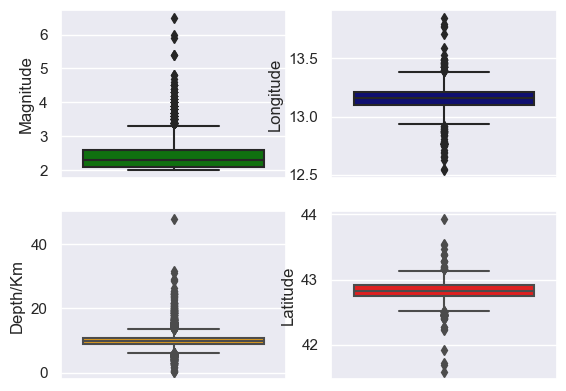

In [8]:
sns.set()
gbox, axes = plt.subplots(2, 2)
sns.boxplot(data=df,y='Magnitude',ax=axes[0,0],color='green')
sns.boxplot(data=df,y='Longitude',ax=axes[0,1],color='navy')
sns.boxplot(data=df,y='Depth/Km',ax=axes[1,0],color='orange')
sns.boxplot(data=df,y='Latitude',ax=axes[1,1],color='red')

In [9]:
#TO-DO
#-Decidir si indexar el dataset con la columna Time
#-Normalizar datos con Zscore
#-Realizar aproximaciones y pruebas de hipotesis para las variables
#-Despues del EDA se observa si se puede clasificar su magnitud en terminos de sus demas variables.
#-Realizar entonces clustering con dbscan o mirar un mejor metodo
#-Caso tal observar distintas distancias haciendo hincapie en la distancia de mahalanobis

<AxesSubplot:xlabel='Magnitude', ylabel='Depth/Km'>

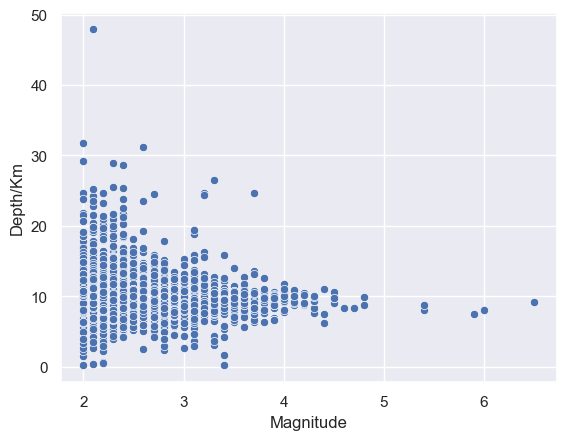

In [10]:
sns.scatterplot(data=df,x='Magnitude',y='Depth/Km')

<AxesSubplot:xlabel='Magnitude', ylabel='Latitude'>

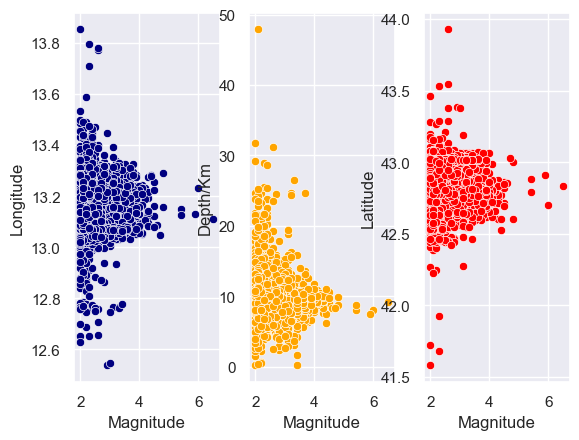

In [11]:
sns.set()
gscar, axes = plt.subplots(1, 3)
#sns.scatterplot(data=df,x='Depth/Km',y='Magnitude',ax=axes[0,0],color='green')
sns.scatterplot(data=df,y='Longitude',x='Magnitude',ax=axes[0],color='navy')
sns.scatterplot(data=df,y='Depth/Km',x='Magnitude',ax=axes[1],color='orange')
sns.scatterplot(data=df,y='Latitude',x='Magnitude',ax=axes[2],color='red')

<AxesSubplot:xlabel='Latitude', ylabel='Magnitude'>

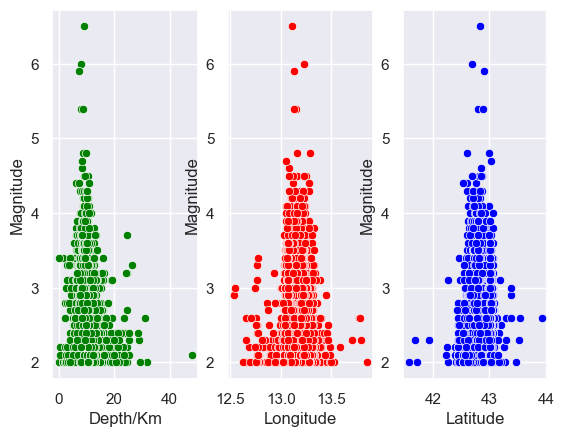

In [12]:
sns.set()
gscar2, axes = plt.subplots(1, 3)
sns.scatterplot(data=df,x='Depth/Km',y='Magnitude',ax=axes[0],color='green')
sns.scatterplot(data=df,x='Longitude',y='Magnitude',ax=axes[1],color='red')
sns.scatterplot(data=df,x='Latitude',y='Magnitude',ax=axes[2],color='blue')
#sns.scatterplot(data=df,x='Depth/Km',y='Magnitude',ax=axes[1,1],color='yellow')

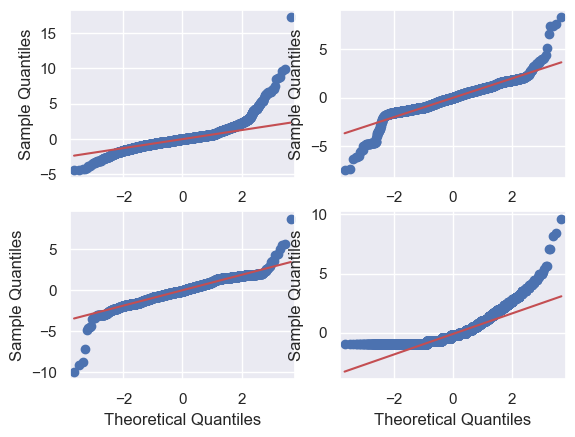

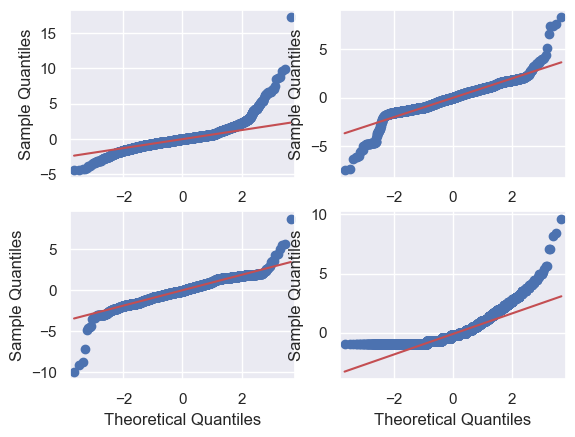

In [13]:
sns.set()
gqdur, axes = plt.subplots(2, 2)
sm.qqplot(data=df['Depth/Km'] , dist=stats.norm ,fit=True ,ax=axes[0,0], line= 'q')
sm.qqplot(data=df['Longitude'] , dist=stats.norm ,fit=True ,ax=axes[0,1], line= 'q')
sm.qqplot(data=df['Latitude'] , dist=stats.norm ,fit=True ,ax=axes[1,0], line= 'q')
sm.qqplot(data=df['Magnitude'] , dist=stats.norm ,fit=True ,ax=axes[1,1], line= 'q')

In [31]:
df['MagnitudeNorm']=(df['Magnitude']-df['Magnitude'].mean())/(df['Magnitude'].std())
df['DepthNorm']=(df['Depth/Km']-df['Depth/Km'].mean())/(df['Depth/Km'].std())
df['LatitudeNorm']=(df['Latitude']-df['Latitude'].mean())/(df['Latitude'].std())
df['LongitudeNorm']=(df['Longitude']-df['Longitude'].mean())/(df['Longitude'].std())

<AxesSubplot:ylabel='LatitudeNorm'>

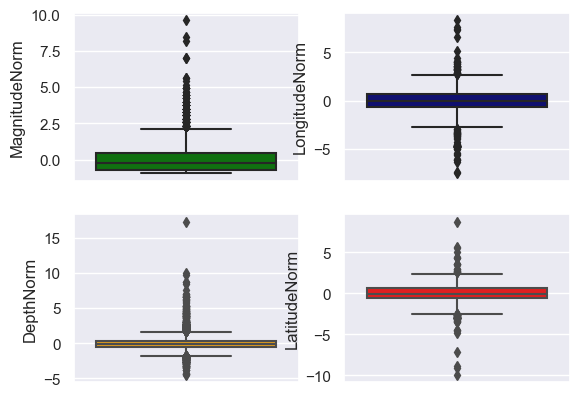

In [39]:
sns.set()
gboxNorm, axes = plt.subplots(2, 2)
sns.boxplot(data=df,y='MagnitudeNorm',ax=axes[0,0],color='green')
sns.boxplot(data=df,y='LongitudeNorm',ax=axes[0,1],color='navy')
sns.boxplot(data=df,y='DepthNorm',ax=axes[1,0],color='orange')
sns.boxplot(data=df,y='LatitudeNorm',ax=axes[1,1],color='red')

<AxesSubplot:xlabel='LatitudeNorm', ylabel='MagnitudeNorm'>

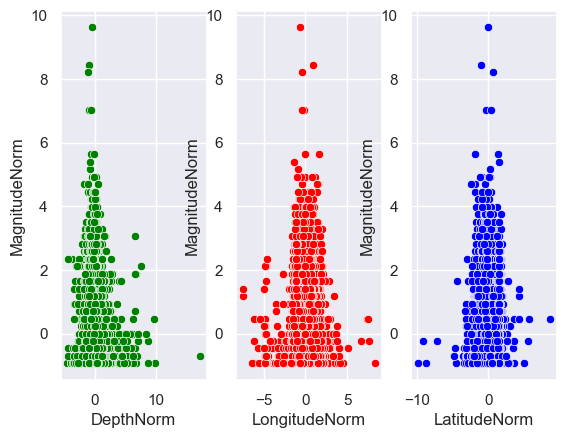

In [41]:
sns.set()
gscar2, axes = plt.subplots(1, 3)
sns.scatterplot(data=df,x='DepthNorm',y='MagnitudeNorm',ax=axes[0],color='green')
sns.scatterplot(data=df,x='LongitudeNorm',y='MagnitudeNorm',ax=axes[1],color='red')
sns.scatterplot(data=df,x='LatitudeNorm',y='MagnitudeNorm',ax=axes[2],color='blue')